# Mapping of registered lightning arroud CG stroke

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from datetime import timezone
import datetime as dt
import json
from IPython.display import Image as ImageDisp
from pandas import DataFrame
import string
import os
import glob
import matplotlib.pyplot as plt
#%pylab inline --no-import-all
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import time
os.environ['TZ'] = 'UTC'
time.tzset()
import matplotlib.colors as colors


hdr_t = np.dtype([
    ('magic', 'u4'),
    ('id', 'u4'),
    ('timestamp', 'u4'),
    ('gps_flags', 'u1'),
    ('gps_sat', 'u1'),
    ('gps_lat', 'f4'),
    ('gps_long', 'f4'),
    ('gps_alt', 'u2'),
    ('gps_hour', 'u1'),
    ('gps_min', 'u1'),
    ('gps_sec', 'u1'),
    ('num_energy_data', 'u2'),
], align=True)

energy_data_t = np.dtype([
    ('info', 'u1'),
    ('timestamp_us', 'u4'),
    ('energy', 'f4'),
], align=True)

def read_rt_dat_file(filename):
    ret_dtype = np.dtype([
        ('time', 'u4'),
        ('time_us', 'u4'),
        ('energy', 'f4'),
        ('info', 'u1'),
        ('gps_lat', 'f4'),
        ('gps_long', 'f4'),
        ('gps_alt', 'u2')
    ])
    
    ret = np.zeros(0, dtype=ret_dtype)
    pieces = []

    with open(filename, 'r') as f:
        while True:
            try:
                hdr = np.fromfile(f, dtype=hdr_t, count=1)[0]
            except IndexError:
                break
            if hdr['magic'] != 0xaaaabbbb:
                raise Exception('corrupted data, magic mismatch')
                
            energy_data = np.fromfile(f, dtype=energy_data_t, count=hdr['num_energy_data'])
            piece = np.zeros(len(energy_data), dtype=ret_dtype)
            piece['time'] = hdr['timestamp']
            piece['time_us'] = energy_data['timestamp_us']
            piece['energy'] = energy_data['energy']
            piece['info'] = energy_data['info']
            piece['gps_lat'] = hdr['gps_lat']
            piece['gps_long'] = hdr['gps_long']
            piece['gps_alt'] = hdr['gps_alt']
            pieces.append(piece)
    return np.concatenate(pieces)

In [81]:
lat=49.5719158
lon=15.9327817
lat=48.7502778
lon=16.3838889
lat=49.5257244
lon=16.5423417

start=pd.Timestamp('2021-07-08 16:14')
end=pd.Timestamp('2021-07-08 16:16')
start=pd.Timestamp('2021-07-14 5:14')
end=pd.Timestamp('2021-07-14 5:15')
start=pd.Timestamp('2021-07-17 14:57')
end=pd.Timestamp('2021-07-17 14:58')

print(start, end, lat, lon)
region=1

### url for json data preparation
url=[]

for i in range(0,int(np.ceil((end-start).total_seconds()/600)+1)):
    next=start+ pd.Timedelta(minutes=i*10)
    url.append('http://data.blitzortung.org/Data/Restricted/Strikes_%01d/%02d/%02d/%02d/%02d/%02d.json' % (region, next.year, next.month, next.day, next.hour, np.floor((next.minute)//10)*10))

import requests
blitz=pd.DataFrame()
for i in range(len(url)):
    try:
        html = requests.get(url[i]).content
        blitz_part = pd.read_json(html,lines=True)
        #blitz_part.drop(columns=['status','sig'], inplace=True)#,'region', 
        blitz=blitz.append(blitz_part)
    except:
        print("No data", url[i])
        pass
blitz.set_index(['time'], inplace=True)

### reduction of too distant events
blitz=blitz[(blitz['lat']>(lat-2) )&(blitz['lat']<(lat+2) )]
blitz=blitz[(blitz['lon']>(lon-3.5) )&(blitz['lon']<(lon+3.5) )]

### calculation of distance of events from station
#from math import radians, cos, sin, asin, sqrt, atan2, degrees

try:
    blitz.drop(columns=['alt','pol','region'], inplace=True)
except:
    print('No columns to drop (alt, pol, region)')
    pass
#blitz['time']=blitz.index    
blitz['date'] = pd.to_datetime(blitz.index, unit='ns')
blitz.reset_index(inplace=True)
blitz.set_index('date', inplace=True)

print('end')

2021-07-17 14:57:00 2021-07-17 14:58:00 49.5257244 16.5423417
end


/nix/store/bd5a7gsg47qnkwywa7r5p7vnyyvpakya-python3-3.7.6-env/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/nix/store/bd5a7gsg47qnkwywa7r5p7vnyyvpakya-python3-3.7.6-env/lib/python3.7/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))


http://server.arcgisonline.com/ArcGIS/rest/services/ESRI_StreetMap_World_2D/MapServer/export?bbox=1837032.2749406048,6328599.6609972995,1845937.8342040665,6335440.096351069&bboxSR=3395&imageSR=3395&size=900,691&dpi=96&format=png32&transparent=true&f=image


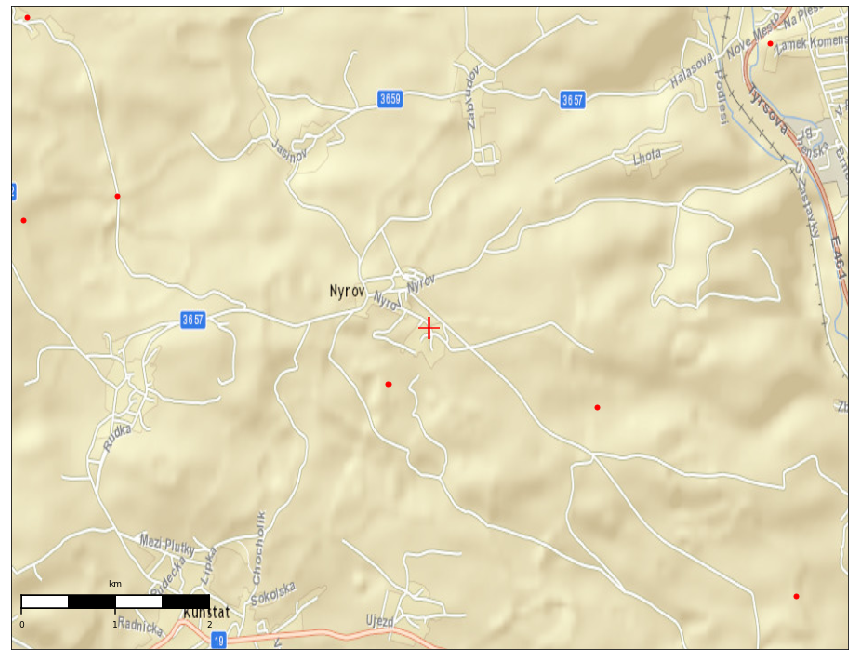

In [82]:
import time, calendar, datetime, numpy
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import urllib, os
import matplotlib
import glob
from matplotlib.colors import LogNorm

matplotlib.rcParams.update({'font.size': 15})

plt.figure(figsize=(15,15))
plt.tight_layout()
m = Basemap(lon_0=0, llcrnrlon=lon-0.04,llcrnrlat=lat-0.02,urcrnrlon=lon+0.04,urcrnrlat=lat+0.02,  epsg = 3395,resolution='i',projection='merc')
m.arcgisimage(service='ESRI_StreetMap_World_2D', xpixels = 900, verbose= True)
m.drawparallels(np.arange(0.,99.,1.),labels=[1,1,0,0], color='gray')
m.drawmeridians(np.arange(0.,20.,1.),labels=[0,0,1,0], color='gray')

x, y = m(blitz.lon.tolist(),blitz.lat.tolist())
H, xedges, yedges = np.histogram2d(x,y)
im1 = m.scatter(x,y, marker='.', s = 100, alpha=1, color='red')

x, y = m([lon],[lat])
im1 = m.scatter(x,y,marker='+', s = 500, color='red')

m.drawmapscale(lon-0.03, lat-0.017 ,lon, lat, 2, barstyle='fancy')

plt.show() 


In [68]:
blitz

,time,lat,lon,mds,mcg,status,sig
date,,,,,,,
2021-07-17 14:50:03.920922172,1626533403920922172,47.899007,17.612533,6035,88,0,"[{'sta': 1936, 'time': -38882, 'lat': 48.29626..."
2021-07-17 14:50:55.455752354,1626533455455752354,48.332931,19.144948,9688,75,0,"[{'sta': 1762, 'time': 145032, 'lat': 48.33896..."
2021-07-17 14:50:55.455758025,1626533455455758025,48.342169,19.107163,10494,161,0,"[{'sta': 943, 'time': 815488, 'lat': 47.683983..."
2021-07-17 14:50:55.455911846,1626533455455911846,48.322970,19.098293,14654,208,0,"[{'sta': 1885, 'time': 1017130, 'lat': 45.3300..."
2021-07-17 14:50:55.455917293,1626533455455917293,48.377188,19.070423,11174,231,0,"[{'sta': 952, 'time': 1428273, 'lat': 52.37596..."
...,...,...,...,...,...,...,...
2021-07-17 15:09:16.638948880,1626534556638948880,49.530402,16.347464,6516,250,0,"[{'sta': 2102, 'time': 2392462, 'lat': 46.9362..."
2021-07-17 15:09:16.638934214,1626534556638934214,49.635424,16.459272,7283,233,0,"[{'sta': 2113, 'time': 2554217, 'lat': 50.6382..."
2021-07-17 15:09:16.638901335,1626534556638901335,49.520804,16.558419,4351,208,0,"[{'sta': 2253, 'time': 2853113, 'lat': 56.0848..."
